In [39]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [40]:
#Data cleaning

df = pd.read_csv('data.csv', parse_dates = ['game_date'], infer_datetime_format = True)
df.set_index('shot_id', inplace=True)
X = df.copy()
print X.isnull().sum()

action_type              0
combined_shot_type       0
game_event_id            0
game_id                  0
lat                      0
loc_x                    0
loc_y                    0
lon                      0
minutes_remaining        0
period                   0
playoffs                 0
season                   0
seconds_remaining        0
shot_distance            0
shot_made_flag        5000
shot_type                0
shot_zone_area           0
shot_zone_basic          0
shot_zone_range          0
team_id                  0
team_name                0
game_date                0
matchup                  0
opponent                 0
dtype: int64


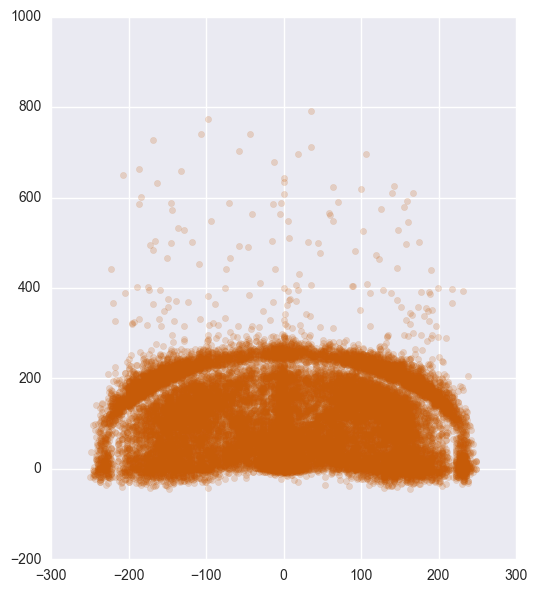

In [41]:
# visualize locx,y
plt.figure(figsize=(6,7))
plt.scatter(X['loc_x'],X['loc_y'], color='#c65b08', alpha=0.2)

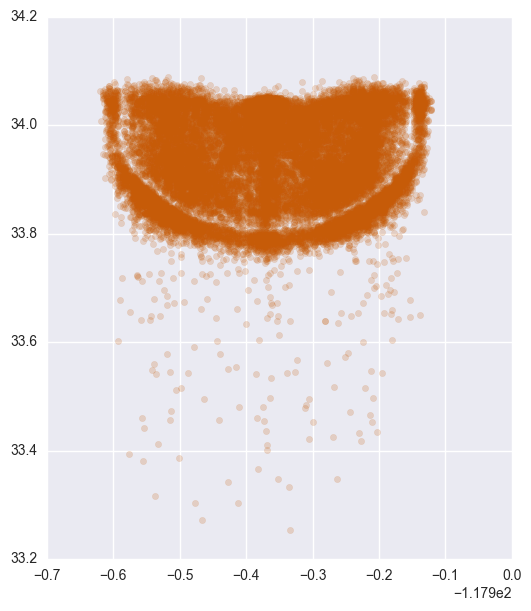

In [42]:
# visualize lat,lon
plt.figure(figsize=(6,7))
plt.scatter(X['lon'],X['lat'], color='#c65b08', alpha=0.2)

In [43]:
#Data cleaning
# drop columns with only 1 feature
X.drop(['game_event_id'], axis = 1, inplace = True) #independent
X.drop(['game_id'], axis = 1, inplace = True) #independent
X.drop(['team_id'], axis = 1, inplace = True) #independent
X.drop(['team_name'], axis = 1, inplace = True) #single value
X.drop(['matchup'], axis = 1, inplace = True) #duplicate with opponent
X.drop(['season'], axis = 1, inplace = True) #duplicate to date/independent
X.drop(['lat'], axis = 1, inplace = True) #keeping locx,y
X.drop(['lon'], axis = 1, inplace = True) #keeping locx,y
X.drop(['shot_zone_range'], axis=1, inplace = True)
X.drop(['game_date'],axis=1,inplace = True)

X['remaining_time'] = X['minutes_remaining'] * 60 + X['seconds_remaining']

#make dummy Variable
pd.set_option('display.max_rows', 200)
X_dummies = pd.get_dummies(X[['action_type', 'combined_shot_type','shot_type','shot_zone_area','shot_zone_basic','opponent' ]], drop_first=True)
X_nondum = X.drop(['action_type','minutes_remaining', 'seconds_remaining','combined_shot_type','shot_type','shot_zone_area','shot_zone_basic','opponent'], axis = 1)
X = pd.concat([X_nondum,X_dummies], axis =1)

In [44]:
#split test and prediction
X_submission = X[pd.isnull(X['shot_made_flag'])]
X_submission = X_submission.drop('shot_made_flag', 1)
X = X[X['shot_made_flag']>=0] # remove null rows


In [45]:
y = X['shot_made_flag']
X.drop(['shot_made_flag'], axis = 1, inplace = True) #target
print y.head()
print X.dtypes

shot_id
2    0.0
3    1.0
4    0.0
5    1.0
6    0.0
Name: shot_made_flag, dtype: float64
loc_x                                             int64
loc_y                                             int64
period                                            int64
playoffs                                          int64
shot_distance                                     int64
remaining_time                                    int64
action_type_Alley Oop Layup shot                  uint8
action_type_Cutting Finger Roll Layup Shot        uint8
action_type_Cutting Layup Shot                    uint8
action_type_Driving Bank shot                     uint8
action_type_Driving Dunk Shot                     uint8
action_type_Driving Finger Roll Layup Shot        uint8
action_type_Driving Finger Roll Shot              uint8
action_type_Driving Floating Bank Jump Shot       uint8
action_type_Driving Floating Jump Shot            uint8
action_type_Driving Hook Shot                     uint8
action_type_Dr

In [46]:
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2)

#Accuracy 
def accuracy_report(_clf):
    training_accuracy = _clf.score(X_train, y_train)
    test_accuracy = _clf.score(X_test, y_test)
    print "Accuracy on test data: %0.2f%%" % (100 * test_accuracy)
    print "Accuracy on training data: %0.2f%%" % (100 * training_accuracy)
    

print ""
print "KNN:"
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train,y_train)
accuracy_report(knn)


print ""
print "GaussianNB:"
gnb = GaussianNB()
gnb.fit(X_train, y_train)
accuracy_report(gnb)

print ""
print "BernoulliNB:"
clf = BernoulliNB()
clf.fit(X_train, y_train)
accuracy_report(clf)

print ""
print "LogisticRegression:"
#logistic regression?? (week 5)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
accuracy_report(logreg)


print ""
print "Cross val scores:"
print "KNN:", cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()
print "Gaussian:", cross_val_score(gnb, X, y, cv=10, scoring='accuracy').mean()
print "Bernoulli:", cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean()
print "Logistic Regression:", cross_val_score(logreg, X, y, cv=10, scoring='accuracy').mean()


KNN:
Accuracy on test data: 56.42%
Accuracy on training data: 72.16%

GaussianNB:
Accuracy on test data: 61.63%
Accuracy on training data: 62.33%

BernoulliNB:
Accuracy on test data: 65.35%
Accuracy on training data: 65.01%

LogisticRegression:
Accuracy on test data: 67.89%
Accuracy on training data: 68.24%

Cross val scores:
KNN: 0.56142718194
Gaussian: 0.624236239001
Bernoulli: 0.649804320569
Logistic Regression: 0.681050307215


In [47]:
classifier3 = {'Randomforest':RandomForestClassifier,
               'DecisionTree':DecisionTreeClassifier}

for name, model in classifier3.items():
    for i in range(1,21):
        clf=model(max_depth = i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        print "%s (%s) had an accuracy score of %0.4f"% (name,i, score)

Randomforest (1) had an accuracy score of 0.6089
Randomforest (2) had an accuracy score of 0.6139
Randomforest (3) had an accuracy score of 0.6297
Randomforest (4) had an accuracy score of 0.6579
Randomforest (5) had an accuracy score of 0.6395
Randomforest (6) had an accuracy score of 0.6750
Randomforest (7) had an accuracy score of 0.6590
Randomforest (8) had an accuracy score of 0.6758
Randomforest (9) had an accuracy score of 0.6700
Randomforest (10) had an accuracy score of 0.6739
Randomforest (11) had an accuracy score of 0.6742
Randomforest (12) had an accuracy score of 0.6755
Randomforest (13) had an accuracy score of 0.6694
Randomforest (14) had an accuracy score of 0.6747
Randomforest (15) had an accuracy score of 0.6722
Randomforest (16) had an accuracy score of 0.6747
Randomforest (17) had an accuracy score of 0.6702
Randomforest (18) had an accuracy score of 0.6702
Randomforest (19) had an accuracy score of 0.6683
Randomforest (20) had an accuracy score of 0.6638
DecisionT

In [48]:
X_submission.head()

,loc_x,loc_y,period,playoffs,shot_distance,remaining_time,action_type_Alley Oop Layup shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,...,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS
shot_id,,,,,,,,,,,,,,,,,,,,,
1,167,72,1,0,18,627,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
8,1,28,3,0,2,485,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
17,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
20,0,0,3,0,0,646,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
33,163,76,1,0,17,686,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [49]:
#using best model for prediction: logreg
pred = logreg.predict_proba(X_submission)
sub = pd.read_csv("sample_submission.csv")
sub['shot_made_flag'] = pred
sub.to_csv("submission.csv", index=False)